In [3]:
# Import necessary packages
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# Helper function to check if two blocks share an edge
def shares_edge(block_a, block_b):
    # Check for shared vertical edges
    if (block_a['x2'] == block_b['x1'] and max(block_a['y1'], block_b['y1']) < min(block_a['y3'], block_b['y3'])) or \
        (block_a['x1'] == block_b['x2'] and max(block_a['y1'], block_b['y1']) < min(block_a['y3'], block_b['y3'])):
        return True
    # Check for shared horizontal edges
    if (block_a['y3'] == block_b['y1'] and max(block_a['x1'], block_b['x1']) < min(block_a['x2'], block_b['x2'])) or \
        (block_a['y1'] == block_b['y3'] and max(block_a['x1'], block_b['x1']) < min(block_a['x2'], block_b['x2'])):
        return True
    return False

In [205]:
class PlanarStoLattice:
    def __init__(self, time = 1, load_lattice = False, lattice_path = "lattice_with_neighbors.csv"):
        self.blocks = [{
            'x1': 0, 'y1': 0,
            'x2': 1, 'y2': 0,
            'x3': 1, 'y3': 1,
            'x4': 0, 'y4': 1,
            'xlen': 1, 'ylen': 1,
            'neighbors': None}]
        self.time = time
        self.num_of_blocks = 3*self.time + 1
        self.lattice = None #This will store the dataframe with all information about the lattice
        self.percolation = None #This will store percolation data

        if load_lattice:
            self.lattice = pd.read_csv(lattice_path)
            self.num_of_blocks = len(self.lattice)
            self.time = (self.num_of_blocks - 1)/3

    def generate(self, path = "lattice_with_neighbors.csv"):
        linewidth = 0.4
        # Draw initial square
        plt.hlines([0, 1], 0, 1, linewidth=linewidth)
        plt.vlines([0, 1], 0, 1, linewidth=linewidth)

        for _ in range(self.time):
            # Choose a random block
            selected_idx = random.randint(0, len(self.blocks) - 1)
            selected_block = self.blocks[selected_idx]
    
            # Calculate random lengths
            num_x = random.random() * selected_block['xlen']
            num_y = random.random() * selected_block['ylen']
    
            # Calculate new block coordinates
            x1, y1 = selected_block['x1'], selected_block['y1']
            x2, y2 = x1 + num_x, y1 + num_y
            x3, y3 = selected_block['x2'], selected_block['y4']
    
            # Draw dividing lines
            plt.hlines(y2, x1, x3, linewidth=linewidth)
            plt.vlines(x2, y1, y3, linewidth=linewidth)
    
            # Length of blocks
            l = len(self.blocks)
    
            # Create new blocks
            block_1 = {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y1, 'x3': x2, 'y3': y2, 'x4': x1, 'y4': y2, 'xlen': num_x, 'ylen': num_y, 'neighbors':[l, l+2]}
            block_2 = {'x1': x2, 'y1': y1, 'x2': x3, 'y2': y1, 'x3': x3, 'y3': y2, 'x4': x2, 'y4': y2, 'xlen': x3-x2, 'ylen': num_y, 'neighbors':[selected_idx, l+1]}
            block_3 = {'x1': x2, 'y1': y2, 'x2': x3, 'y2': y2, 'x3': x3, 'y3': y3, 'x4': x2, 'y4': y3, 'xlen': x3-x2, 'ylen': y3-y2, 'neighbors':[l, l+2]}
            block_4 = {'x1': x1, 'y1': y2, 'x2': x2, 'y2': y2, 'x3': x2, 'y3': y3, 'x4': x1, 'y4': y3, 'xlen': num_x, 'ylen': y3-y2, 'neighbors':[selected_idx, l+1]}
    
            #Save parents neighbors
            neighbors = self.blocks[selected_idx]['neighbors']
    
            # Replace the selected block with the new blocks
            self.blocks[selected_idx] = block_1
            self.blocks.extend([block_2, block_3, block_4])
    
            #Update neighbors
            if neighbors is not None:
                for j in neighbors:
                        self.blocks[j]['neighbors'].remove(selected_idx) #Delete selected block index from the previous neighbors
                for i in [selected_idx, l, l+1, l+2]:
                    for j in neighbors:
                        if shares_edge(self.blocks[i], self.blocks[j]):
                            self.blocks[i]['neighbors'].append(j)
                            self.blocks[j]['neighbors'].append(i)
    
        # Convert final list of blocks to a DataFrame
        self.blocks = pd.DataFrame(self.blocks)

        #Count number of neighbors for each block
        self.blocks["number_of_neighbors"] = [len(i) for i in self.blocks["neighbors"]]

        #Area of each block
        self.blocks["area"] = self.blocks["xlen"] * self.blocks["ylen"]
        
        #Save the generated lattice
        self.save_lattice(path = path)
        
        # Save the figure
        plt.savefig("lattice_image.png", dpi=1000)

    def save_lattice(self, path = "lattice_with_neighbors.csv"):
        self.blocks.to_csv(path, index=False)

    def save_percolation(self, path = "percolation_data.csv"):
        self.percolation.to_csv(path, index=False)

    def percolate(self, path = "percolation_data.csv"):
        #Generate random sequence of percolation
        list_of_idx = [ i for i in range(self.num_of_blocks)]
        random.shuffle(list_of_idx)

        #Variables to store clusters data and percolation data
        clusters = []
        percolation_data = []

        #Start percolation
        for count, idx in enumerate(list_of_idx):
            #A list of cluster indexes which neighbors list contain the new block
            expanding_clusters_idx = [] 
            
            #Check if the new block is a new cluster or expands existing cluster(s)
            for cluster_idx in range(len(clusters)):
                if idx in clusters[cluster_idx][1]:
                    expanding_clusters_idx.append(cluster_idx)
            
            #If the new block is a new cluster, append its index and list of neighbors to the clusters list
            if len(expanding_clusters_idx) == 0:
                clusters.append([[idx],list(set(self.blocks.loc[idx, "neighbors"]))])
                updated_idx = -1
            
            #Otherwise merge those expanding clusters
            else:
                # If there are multiple expanding clusters that will form a new cluster together
                new_cluster = []
                new_neighbor_list = []
                for idxx in expanding_clusters_idx:
                    new_cluster = new_cluster + clusters[idxx][0]
                    new_neighbor_list = new_neighbor_list + clusters[idxx][1]

                #Add the new block to the new cluster data
                new_cluster = list(set([idx] + new_cluster))
                #Add new block neighbor to the cluster neighbor and remove the cluster blocks from the neighbor
                new_neighbor_list = set(new_neighbor_list + list(self.blocks.loc[idx, "neighbors"]))
                for idxx in new_cluster:
                    if idxx in new_neighbor_list:
                        new_neighbor_list.discard(idxx)
                new_neighbor_list.discard(idx)
                new_neighbor_list = list(new_neighbor_list)

                #Update the clusters list
                #Keep one merged cluster
                clusters[expanding_clusters_idx[0]] = [new_cluster, new_neighbor_list]

                #Note the updated cluster index for later spanning check and then delete it
                updated_idx = expanding_clusters_idx[0]
                del expanding_clusters_idx[0]

                #Delete rest of the clusters that has merged together
                expanding_clusters_idx.reverse()
                for idxx in expanding_clusters_idx:
                    del clusters[idxx]
            
            #Check  if the new expanded cluster spans the lattice
            #Horizontal spanning check
            #Make a set of x coordinates of the cluster members
            does_span = False
            coord_set = pd.concat([self.blocks.loc[clusters[updated_idx][0]]["x1"], self.blocks.loc[clusters[updated_idx][0]]["x2"]])
            if (0 in coord_set.values) and (1 in coord_set.values):
                does_span = True

            #Vertical spanning check        
            coord_set = pd.concat([self.blocks.loc[clusters[updated_idx][0]]["y1"], self.blocks.loc[clusters[updated_idx][0]]["y2"]])
            if (0 in coord_set.values) and (1 in coord_set.values):
                does_span = True

            #Calculate area of each cluster
            clusters_area = [sum(self.blocks.loc[idxx[0], "area"]) for idxx in clusters]
                
            
            #Store necessary data in dictionary
            percolation_data.append({"n":count + 1,
                                    "clusters":[*clusters],
                                    "number_of_clusters":len(clusters),
                                    "does_span":does_span,
                                    "clusters_area":[*clusters_area],
                                    "total_cluster_area": sum(clusters_area),
                                    "occupation_prob":(count+1)/self.num_of_blocks})
        self.percolation = pd.DataFrame(percolation_data)
        self.save_percolation(path = path)


In [206]:
lattice2d = PlanarStoLattice(2)

2.4134583473205566


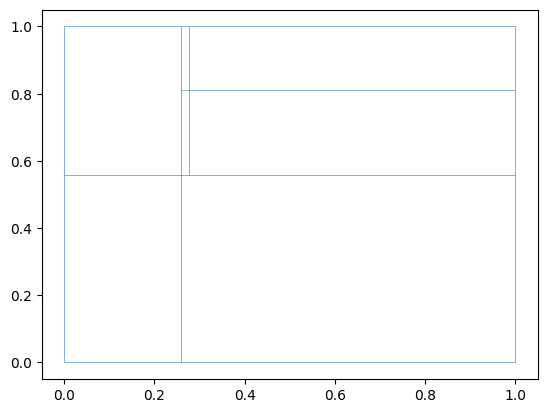

In [207]:
import time

start = time.time()
lattice2d.generate()
end = time.time()
print(end - start)

In [208]:
lattice2d.percolate()